In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


# PROBLEM STATEMENT

This dataset captures phone-based marketing campaigns by a bank, aiming to promote term deposits. It records whether clients subscribed ('yes') or not ('no').

**Feature Details**

* **last contact date**: Date of last contact attempt.
* **age**: Age of the individual.
* **job**: Type of job category.
* **marital**: Marital status (single/married).
* **education**: Level of education attained.
* **default**: Has credit in default.
* **balance**: Account balance in euros.
* **housing**: Has a housing loan (yes/no).
* **loan**: Has a personal loan (yes/no).
* **contact**: Contact communication type.
* **duration**: Duration of last contact (seconds).
* **campaign**: Number of contacts during campaign.
* **pdays**: Days since last contact attempt.
* **previous**: Previous contacts with client.
* **poutcome**: Outcome of prior campaign.
* **target**: Outcome label (yes/no)

# Importing libraries

In [21]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Libraries for Preprocessing
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler,OneHotEncoder,PolynomialFeatures
from sklearn.model_selection import train_test_split

# Libraries for Featue Selection and Model Training
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

#Libraries for Model Evaluation
from scipy.stats import randint as sp_randint, uniform as sp_uniform
from sklearn.metrics import classification_report, confusion_matrix, f1_score


# Data Loading

In [22]:
train_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv")
test_df = pd.read_csv("/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv")
sample_submission = pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv')

In [23]:
train_df.head(5)

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no


# EDA - Explanatory Data Analysis


In [24]:
train_df.describe()


,age,balance,duration,campaign,pdays,previous
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,5441.781719,439.062789,5.108770,72.256051,11.826171
std,12.709352,16365.292065,769.096291,9.890153,160.942593,44.140259
min,18.000000,-8019.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,98.000000,109.000000,1.000000,-1.000000,0.000000
50%,40.000000,549.000000,197.000000,2.000000,-1.000000,0.000000
75%,50.000000,2030.000000,380.000000,4.000000,-1.000000,0.000000
max,95.000000,102127.000000,4918.000000,63.000000,871.000000,275.000000


In [25]:
train_df.isnull().sum()


last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

In [26]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                38982 non-null  object
 3   marital            39211 non-null  object
 4   education          37744 non-null  object
 5   default            39211 non-null  object
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  object
 8   loan               39211 non-null  object
 9   contact            28875 non-null  object
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           9760 non-null   object
 15  target             39211 non-null  object
dtypes: int64(6), object(10)
memory usage: 4.

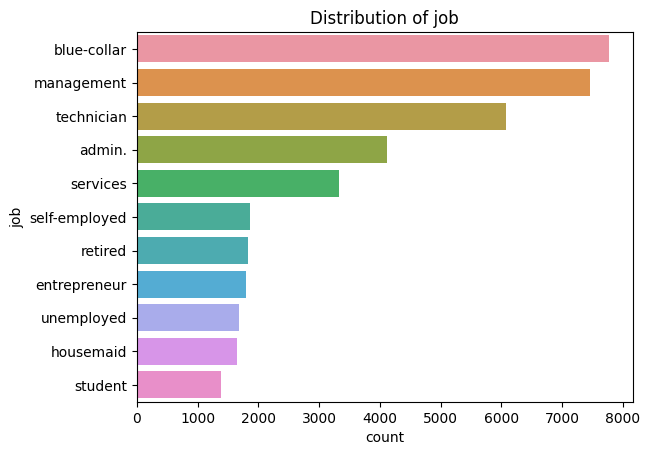

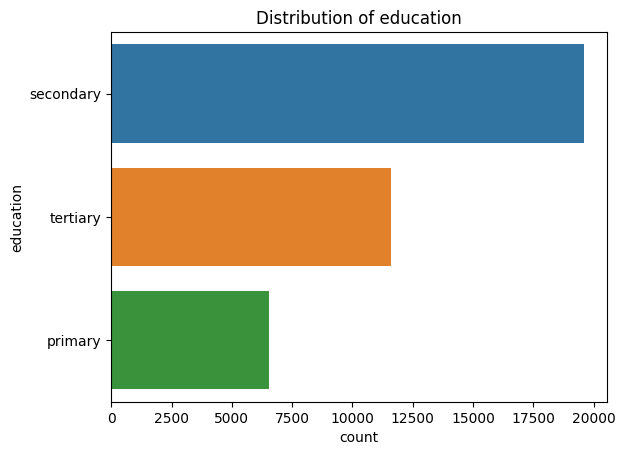

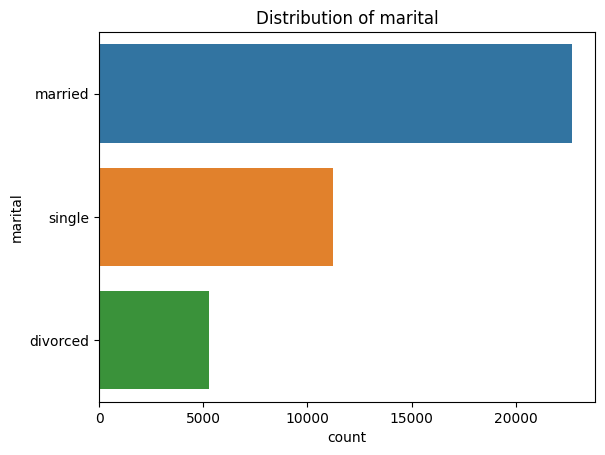

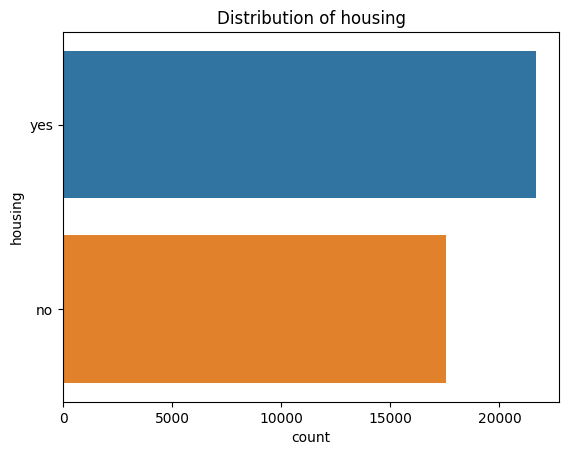

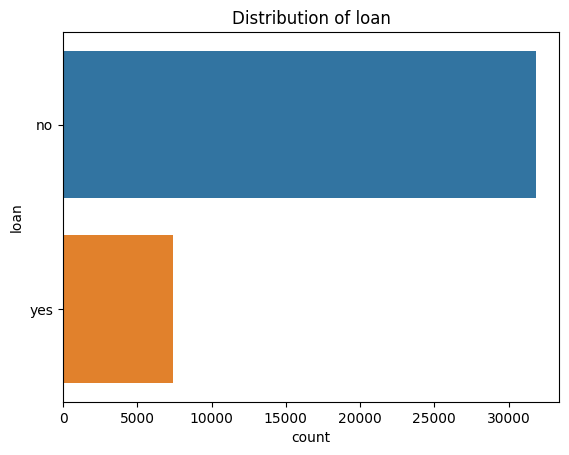

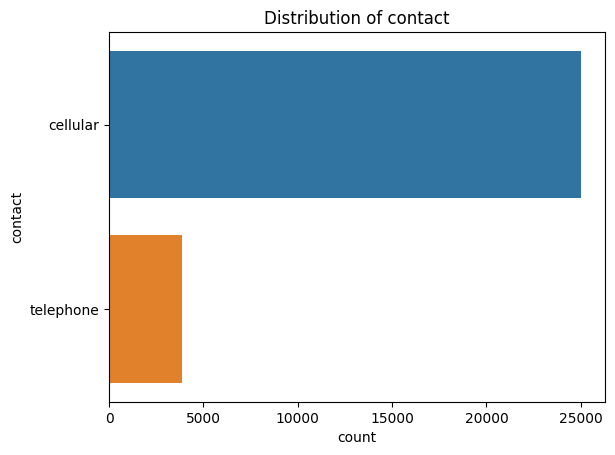

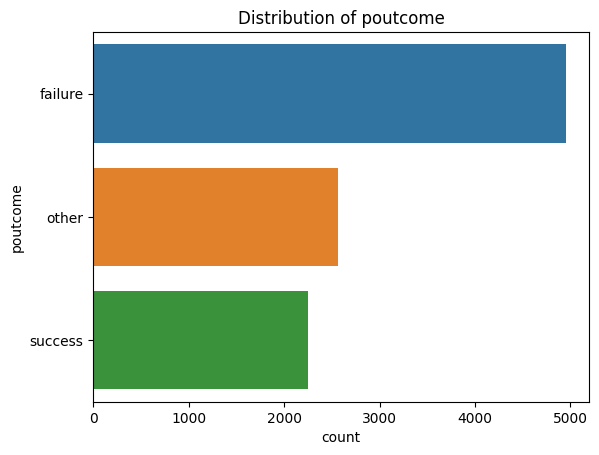

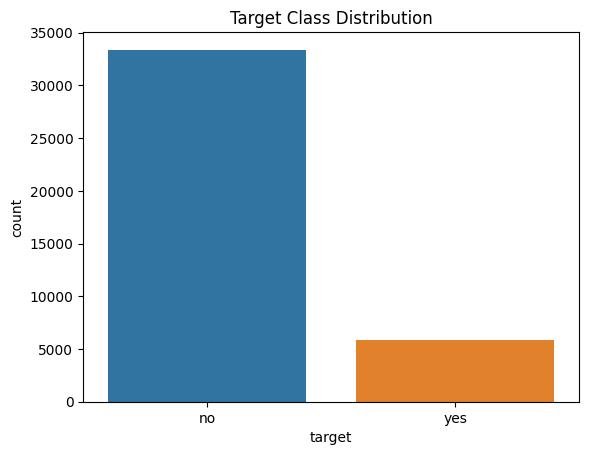

In [27]:
categorical_columns = ['job', 'education', 'marital', 'housing', 'loan', 'contact', 'poutcome']
for col in categorical_columns:
    sns.countplot(y=train_df[col], order=train_df[col].value_counts().index)
    plt.title(f"Distribution of {col}")
    plt.show()
sns.countplot(x='target', data=train_df)
plt.title("Target Class Distribution")
plt.show()

****INSIGHTS****

**Distribution of Job**
The most frequent job types are blue-collar, management, and technician roles.
Management and white-collar jobs (e.g., technician, admin) might correlate positively with success, as these roles typically involve higher income and better financial planning. 

Conversely, blue-collar roles might show a lower subscription rate.
Students and unemployed individuals are less likely to subscribe due to limited financial resources.


**Distribution of Education**
Clients with secondary education dominate the dataset, followed by tertiary and primary.
Higher education levels (tertiary) might be positively correlated with success, as such clients could be more financially stable and **receptive** to investment products.


**Distribution of marital**
Married clients form the largest group, followed by single and divorced clients.
Single clients might have a higher likelihood of subscribing to new offers as they often have fewer financial commitments compared to married or divorced clients.


**Distribution of loan**
Clients with loans might be less likely to opt for new subscriptions due to existing financial commitments.
Thus, clients without loans could be more open to offers.


**Distribution of contact**
The majority of contacts are through cellular, while telephone is much less frequent.
Thus, Cellular contacts may have a higher probability of success due to better accessibility compared to that of a telephone.


**Distribution of Housing**
The distribution is fairly balanced between clients with and without housing loans.
Similar to the above, housing loans might negatively impact the likelihood of success.


**Distribution of poutcome**
Success outcome is the least frequent.


**Distribution of Target Variable**
There is a significant imbalance in the target variable. This indicates that the dataset is biased towards clients not subscribing to the offer. 


In [28]:
num_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
correlation_matrix = train_df[num_features].corr()
print("Correlation Matrix:")
print(correlation_matrix)


Correlation Matrix:
               age   balance  duration  campaign     pdays  previous
age       1.000000  0.289150  0.255573  0.269439  0.199507  0.277487
balance   0.289150  1.000000  0.669737  0.674339  0.562097  0.716816
duration  0.255573  0.669737  1.000000  0.630944  0.527020  0.683951
campaign  0.269439  0.674339  0.630944  1.000000  0.519469  0.689211
pdays     0.199507  0.562097  0.527020  0.519469  1.000000  0.586175
previous  0.277487  0.716816  0.683951  0.689211  0.586175  1.000000


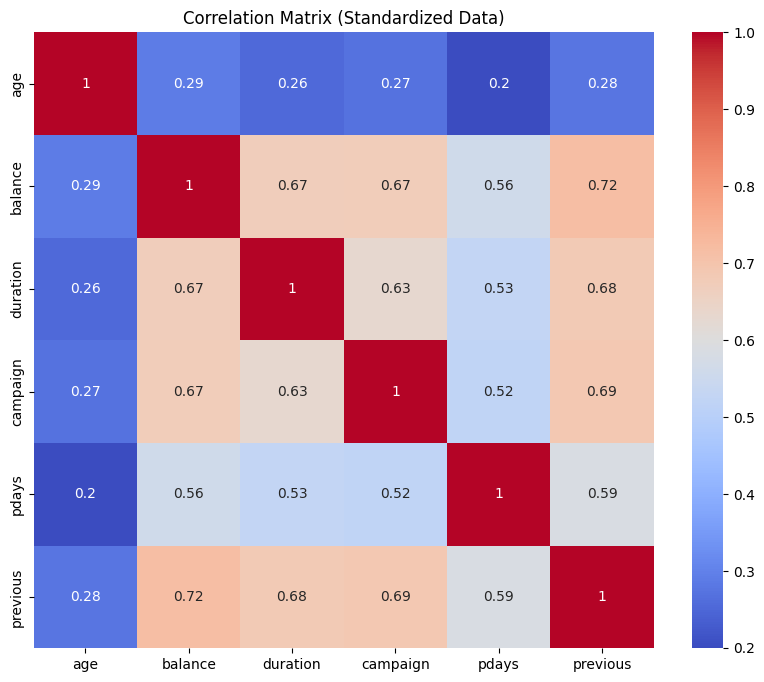

In [29]:
numeric_data = train_df.select_dtypes(include=['float64', 'int64'])

scaler = StandardScaler()
numeric_data_scaled = scaler.fit_transform(numeric_data)

numeric_data_scaled = pd.DataFrame(numeric_data_scaled, columns=numeric_data.columns)

plt.figure(figsize=(10,8))
sns.heatmap(numeric_data_scaled.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Standardized Data)')
plt.show()



****INSIGHTS****

***STRONG CORRELATION***

**Balance and Previous**
*balance* and *previous* have a strong correlation of 0.72

Thus, Customers with high balances tend to havee more previous interactions with tthe bank.

**Duration and Previous**
*duration* and *previous* have a correlation of 0.68

Thus, the longer a customer's last interaction duration, the more likely they've interacted with the bank previously.

**Balance and Duration**
*balance* and *duration* have a correlation of 0.67

Thus, Customers with higher balances tend to have longer interaction durations.

***WEAK CORRELATION***

**Age**
*age* has weak correlations with other variables. 

Thus, Customer age does not significantly impact balance, duration, or campaign interaction.



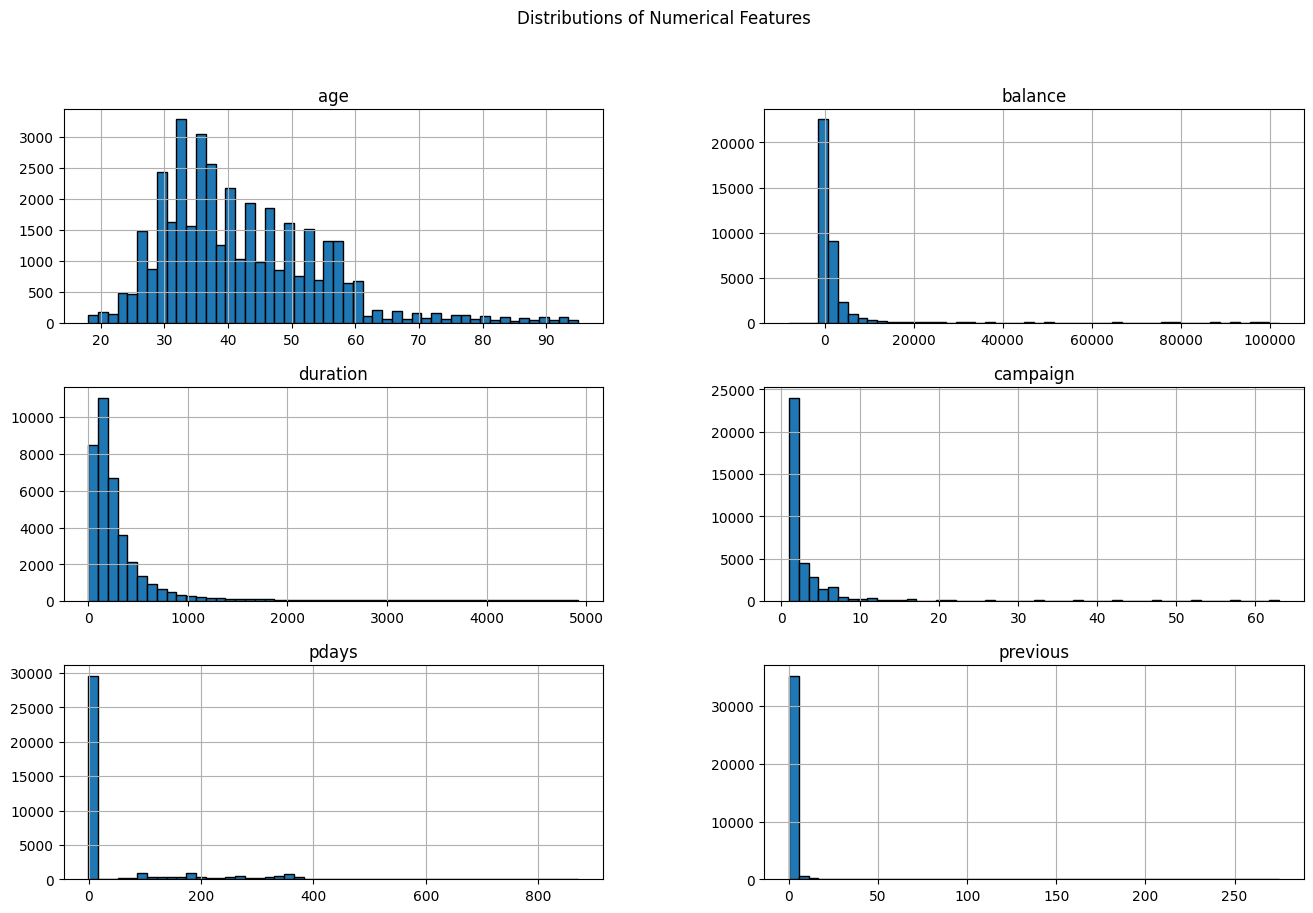

In [30]:
train_df.hist(bins=50, edgecolor='black',figsize=(16,10))
plt.suptitle('Distributions of Numerical Features')
plt.show()

****INSIGHTS****

The dataset is right skewed in many of the features (such as balance, duration, and previous contacts), with a few customers exhibiting extreme values.

Most customers have low balances, few interactions, and short contact durations, with some outliers indicating higher levels of engagement.

The concentration of contacts in specific months and years can help identify seasonal trends or periods of intense campaign activity.

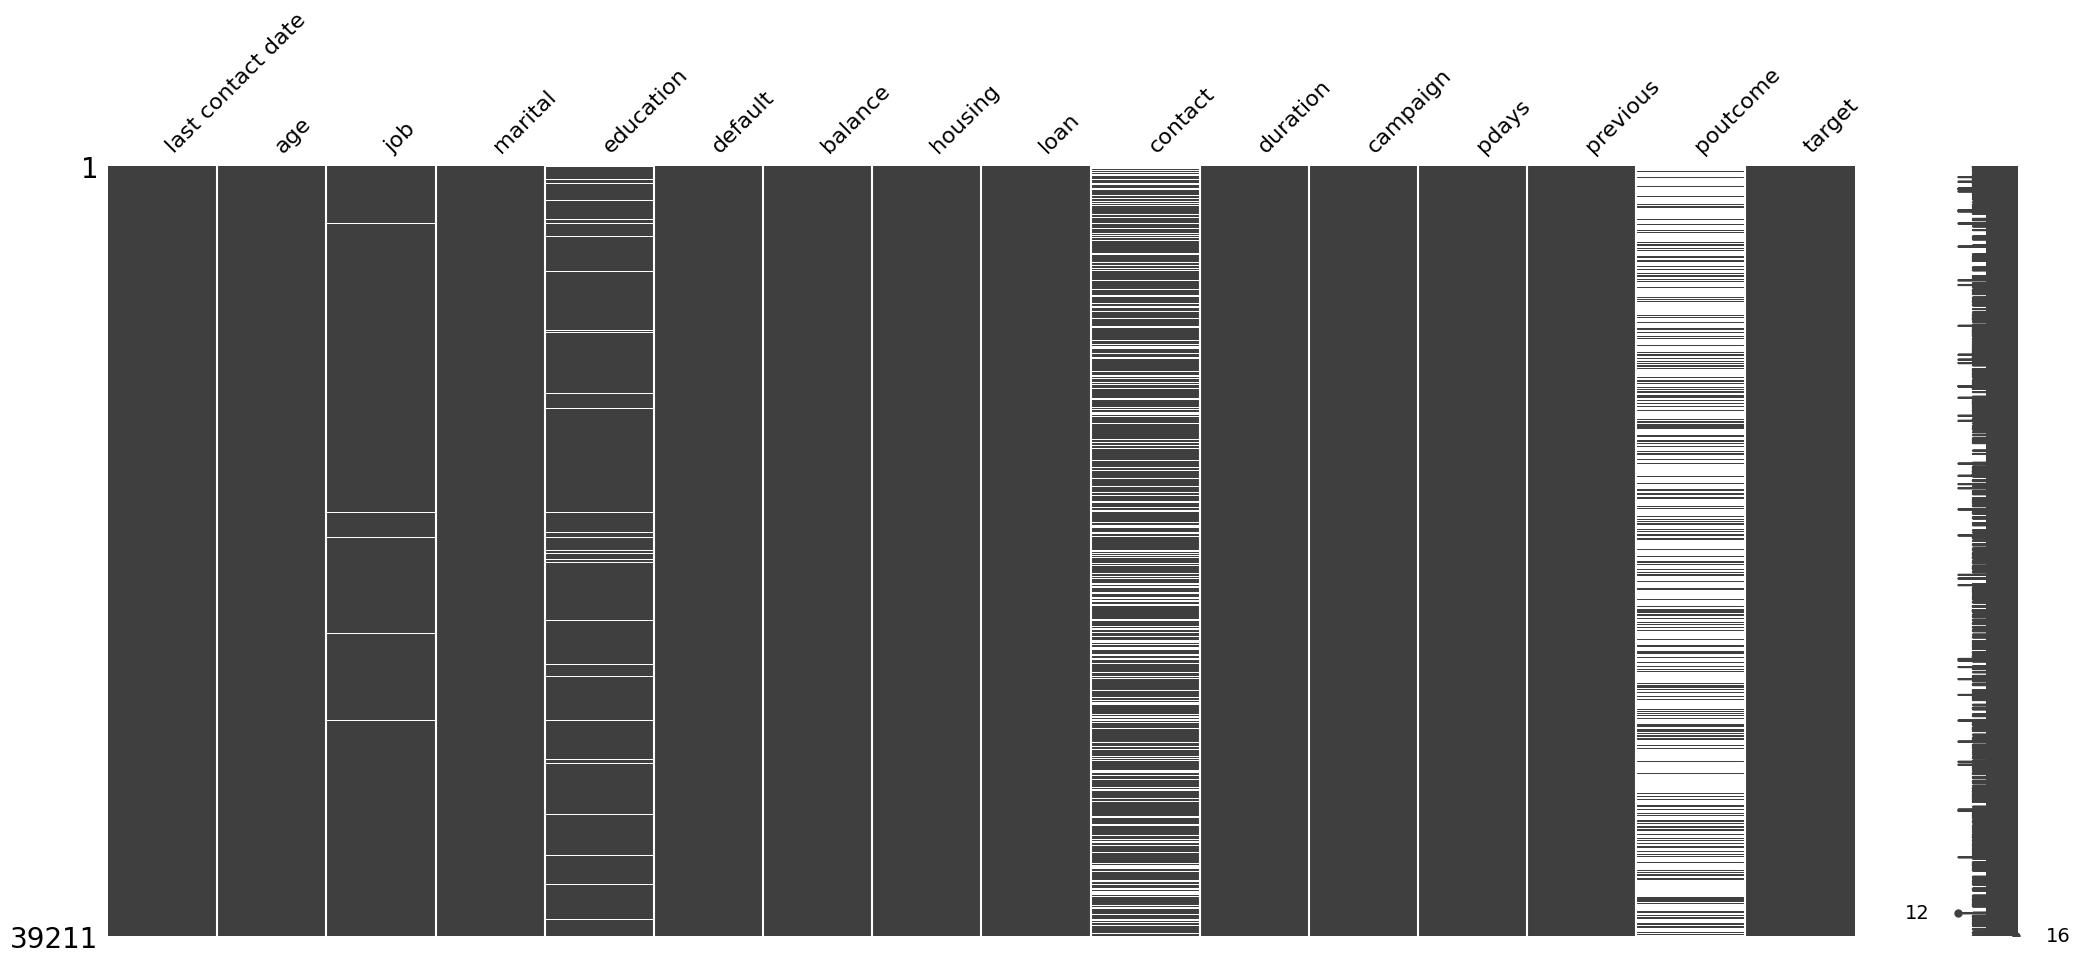

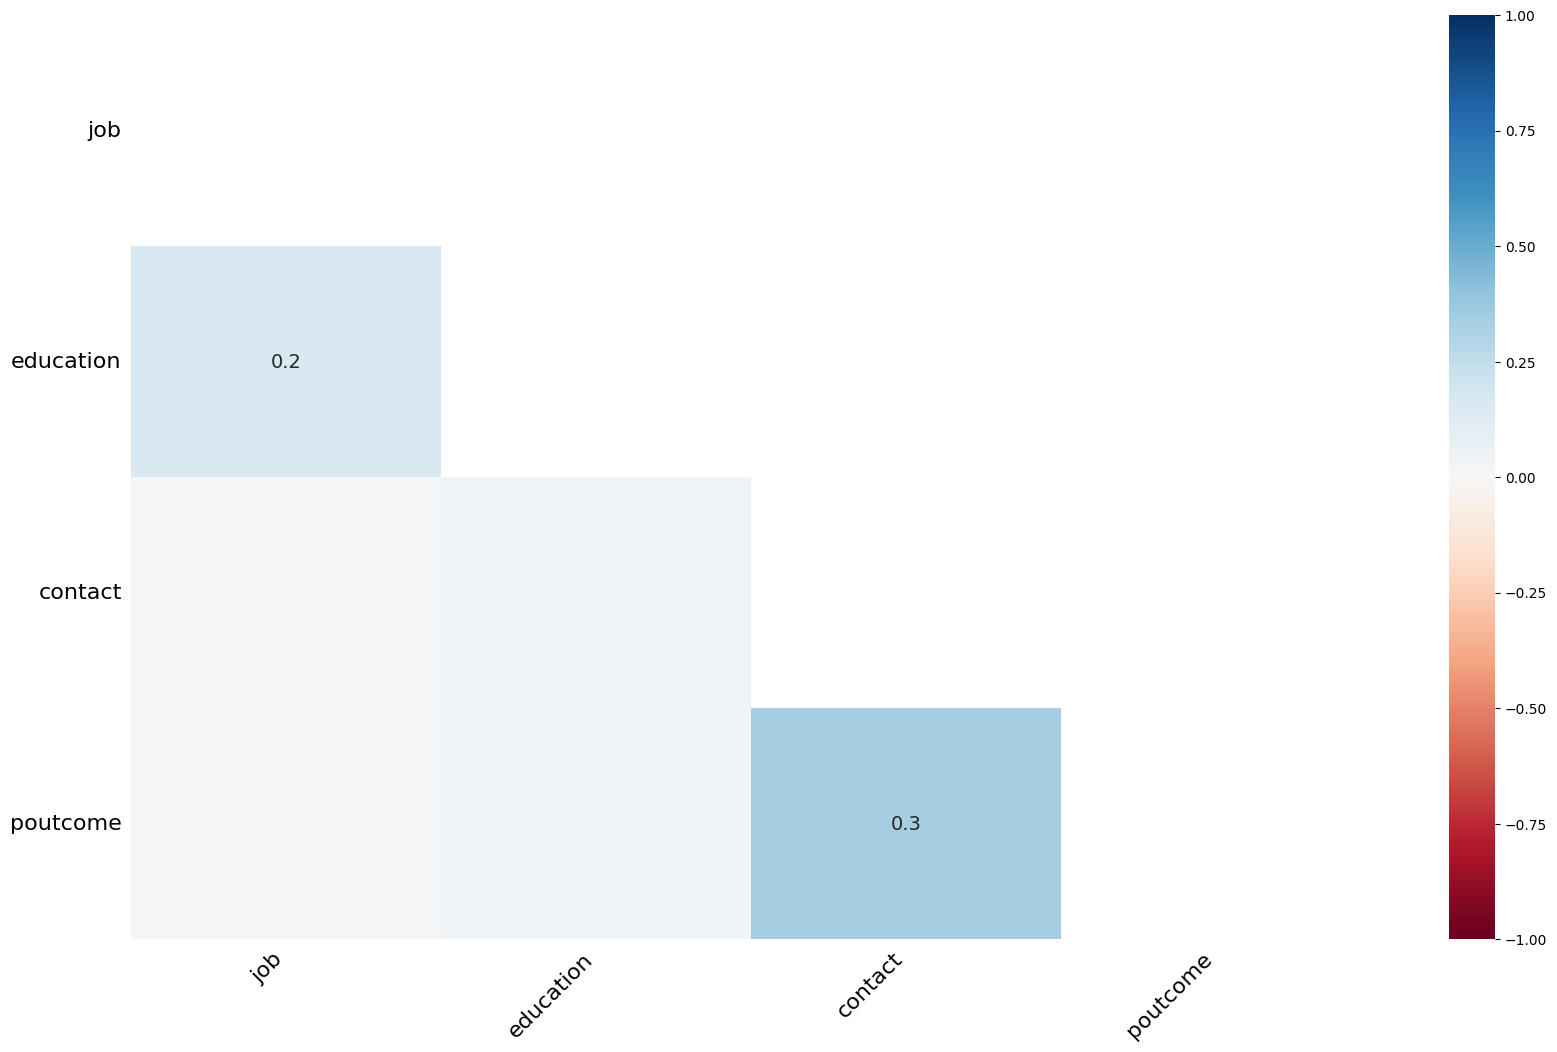

In [31]:
# Visualize missing values
msno.matrix(train_df)
plt.show()

msno.heatmap(train_df)
plt.show()


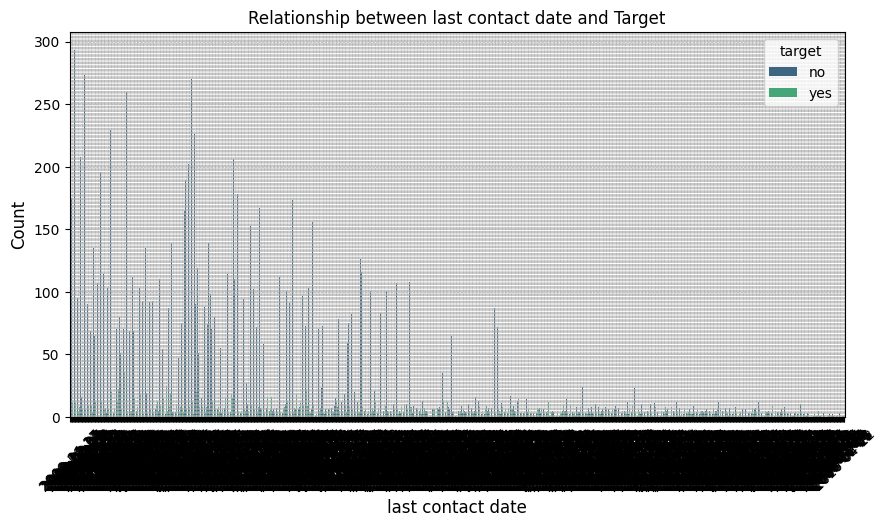

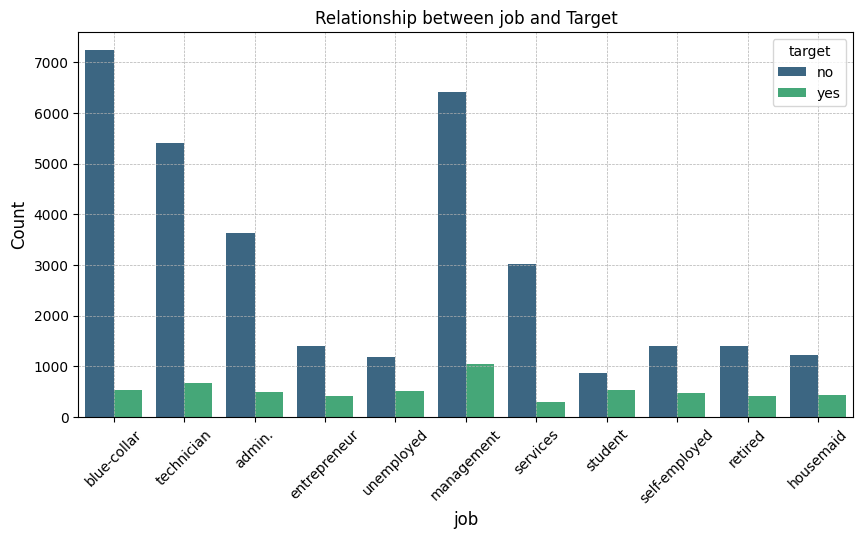

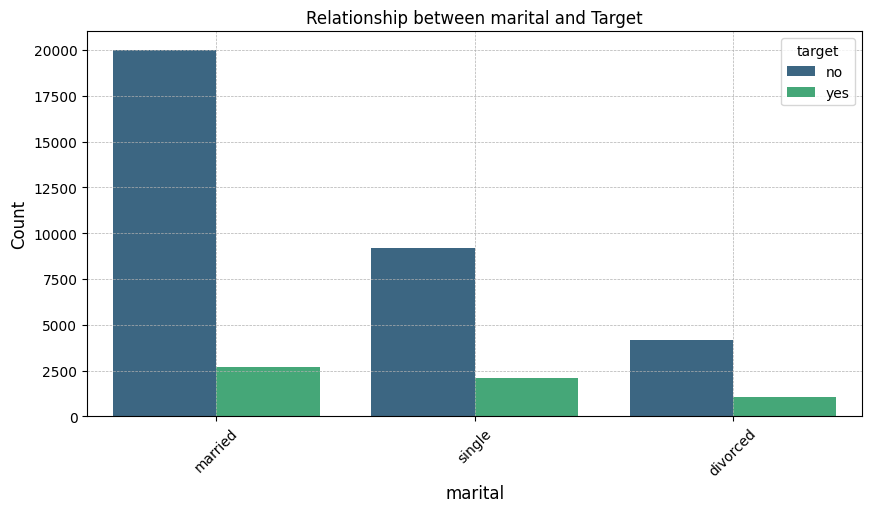

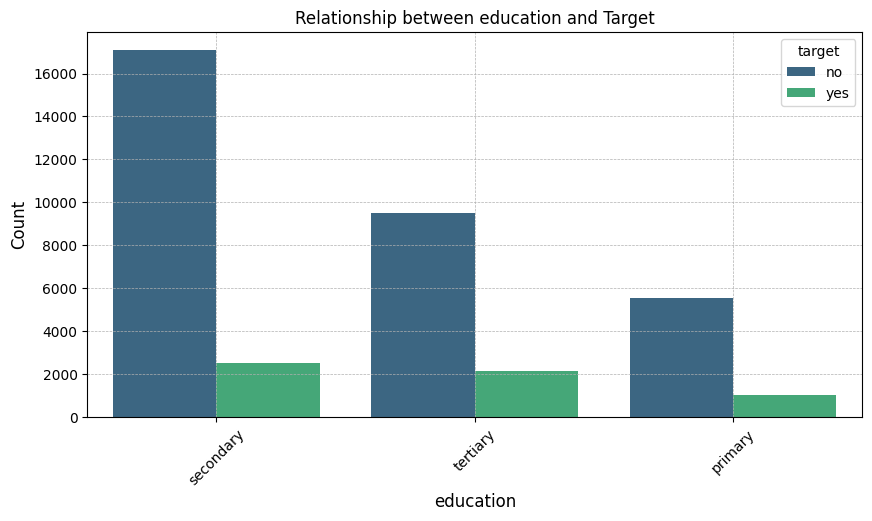

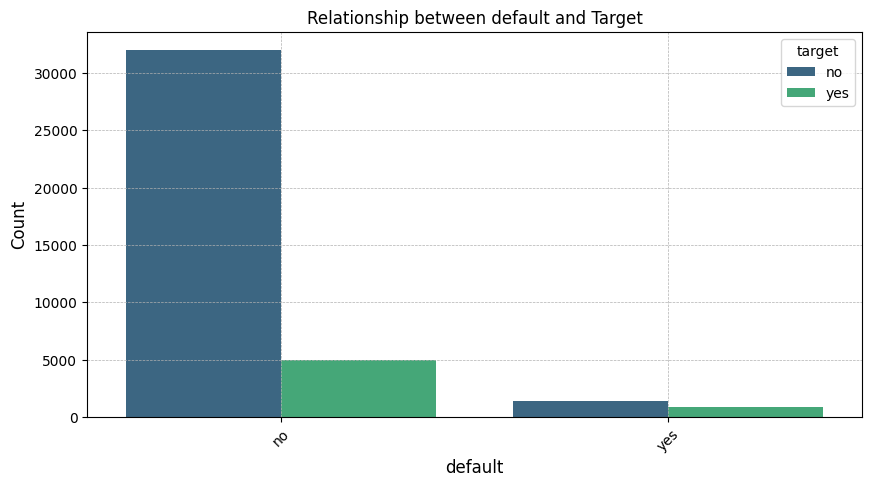

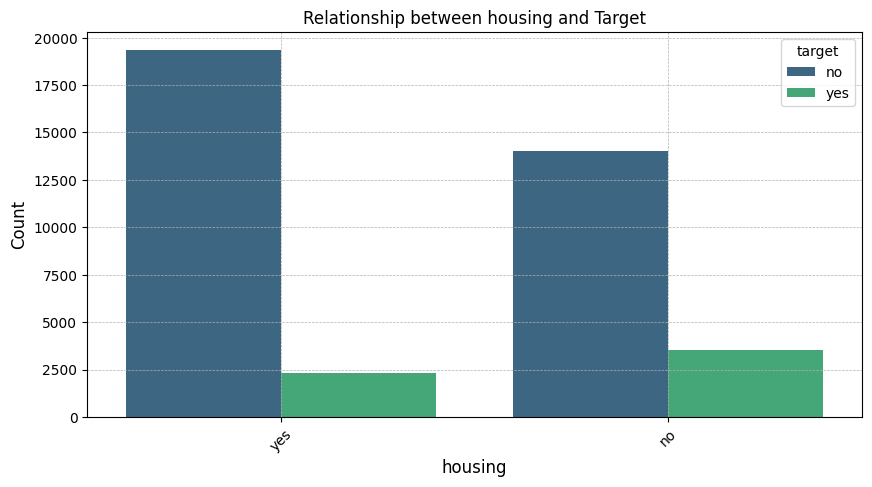

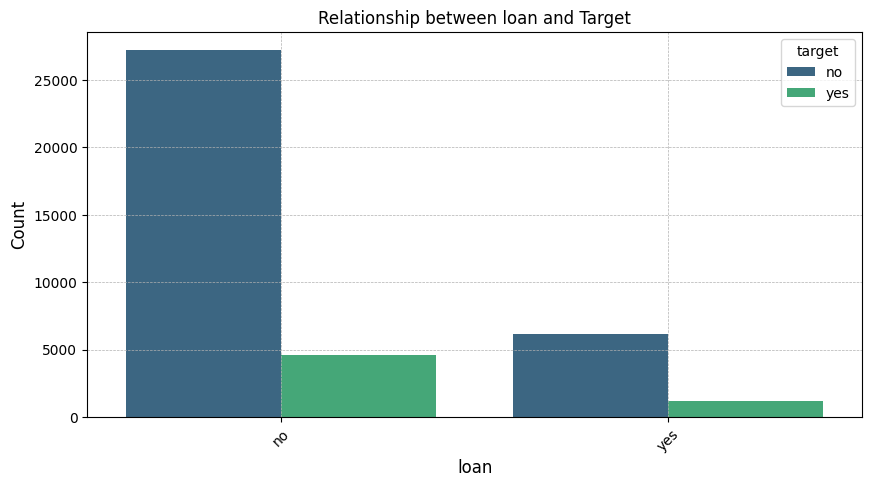

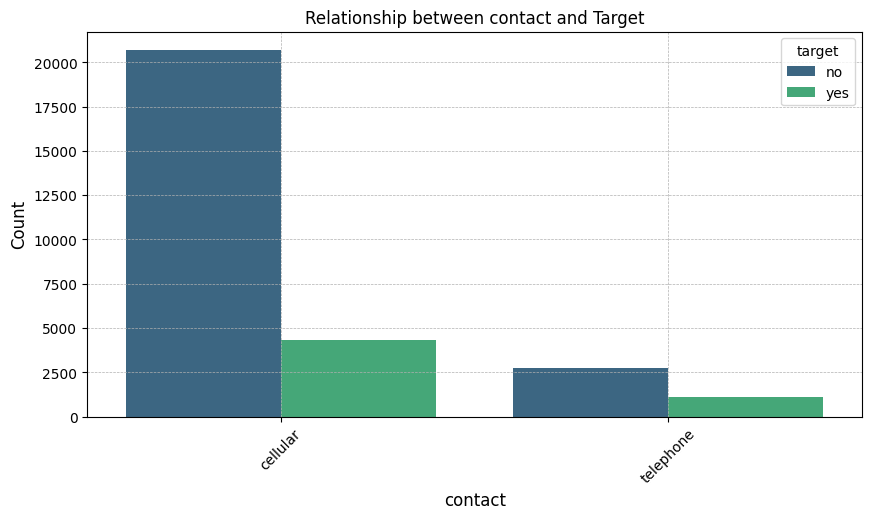

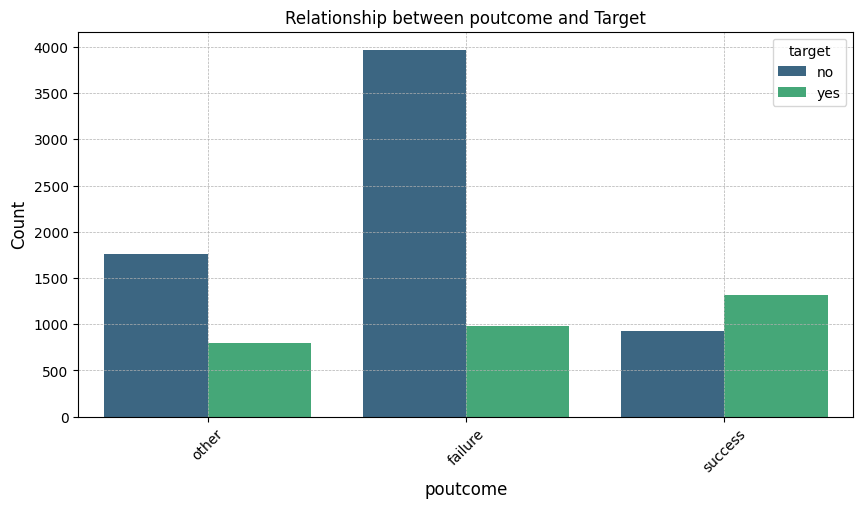

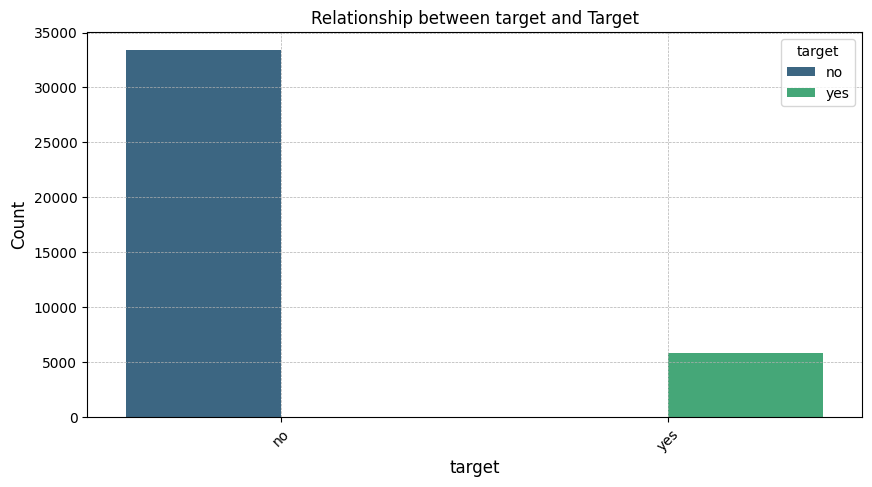

In [32]:
train_df = train_df.dropna(subset=['target'])

cat_features = train_df.select_dtypes(include=['object']).columns

for col in cat_features:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=train_df, x=col, hue='target', palette="viridis")
    plt.title(f"Relationship between {col} and Target")
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(visible=True, which='both', linestyle='--', linewidth=0.5)
    plt.show()

****INSIGHTS****

**job** 
rate of success is higher for *management* and *technician*.

**marital**
*single* shows a higher proportion of success.

**education**
*Tertiary* shows a higher rate of success.

**default**
Very few records contributed to *yes* for success.

**housing**
*no* shows relatively better rate of success.

**loan**
*no* loans has higher rate of success.

**contact**
*cellular* over *telephone*, in terms of success.

**poutcome**
*yes* boost future results, while failures limit them.

# Data Preprocessing and Feature Engineering

In [33]:
def preprocess_data(df):
    df['last contact date'] = pd.to_datetime(df['last contact date'])
    df['contact_year'] = df['last contact date'].dt.year
    df['contact_month'] = df['last contact date'].dt.month
    df['contact_day'] = df['last contact date'].dt.day
    df['contact_dayofweek'] = df['last contact date'].dt.dayofweek
    df.drop('last contact date', axis=1, inplace=True)
    for col in ['job', 'education', 'contact', 'poutcome']:
        df[col] = df[col].fillna('Unknown')
    df_encoded = pd.get_dummies(df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome'])
    return df_encoded


train_df = preprocess_data(train_df)
test_df = preprocess_data(test_df)


test_df = test_df.reindex(columns=train_df.columns, fill_value=0)

In [34]:
X = train_df.drop('target', axis=1)
y = train_df['target'].apply(lambda x: 1 if x == 'yes' else 0)
X_test_final = test_df.drop('target', axis=1)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

# Model Training


***MODEL 1: RANDOM FOREST***

In [35]:
#pipelines
pipeline_rf = Pipeline([
    ('poly', PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', RandomForestClassifier(random_state=42, class_weight='balanced', n_jobs=-1))
])

pipeline_rf

Pipeline(steps=[('poly',
                 PolynomialFeatures(degree=1, include_bias=False,
                                    interaction_only=True)),
                ('scaler', StandardScaler()),
                ('model',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

In [36]:
#hypertuning
param_dist_rf = {
    'model__n_estimators': sp_randint(150, 250),             # Moderate number for consistent results
    'model__max_depth': sp_randint(8, 20),                   # Slightly shallower trees for generalization
    'model__min_samples_split': sp_randint(5, 15),           # Prevents overly fine splits
    'model__min_samples_leaf': sp_randint(2, 6)              # Larger leaves for better stability
}

param_dist_rf

{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7f67ac497cd0>,
 'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7f67d1cde890>,
 'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7f67b18e0580>,
 'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7f67ac41bfa0>}

In [37]:
random_search_rf = RandomizedSearchCV(
    pipeline_rf, 
    param_distributions=param_dist_rf, 
    n_iter=10, 
    cv=StratifiedKFold(3),
    scoring='f1_macro', 
    n_jobs=-1, 
    random_state=42
)

In [38]:
random_search_rf.fit(X_train, y_train)

random_search_rf

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(degree=1,
                                                                 include_bias=False,
                                                                 interaction_only=True)),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              RandomForestClassifier(class_weight='balanced',
                                                                     n_jobs=-1,
                                                                     random_state=42))]),
                   n_jobs=-1,
                   param_distributions={'model__max_depth'...cde890>,
                                        'model__min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f67ac41bfa0>,
                                        'model__min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f67b18e0580>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f67ac497cd0>},
                   random_state=42, scoring='f1_macro')

In [39]:
best_rf = random_search_rf.best_estimator_
y_val_pred_rf = best_rf.predict(X_valid)
f1_rf = f1_score(y_valid, y_val_pred_rf, average='macro')
print(f"Random Forest F1 Score: {f1_rf:.4f}")

Random Forest F1 Score: 0.7705


***MODEL 2: XGBoost***

In [40]:
#pipeline
pipeline_xgb = Pipeline([
    ('poly', PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42, n_jobs=-1))
])

pipeline_xgb

Pipeline(steps=[('poly',
                 PolynomialFeatures(degree=1, include_bias=False,
                                    interaction_only=True)),
                ('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature...grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [41]:
param_dist_xgb = {
    'model__n_estimators': sp_randint(100, 300),
    'model__max_depth': sp_randint(6, 12),
    'model__learning_rate': sp_uniform(0.01, 0.05),
    'model__subsample': sp_uniform(0.8, 0.2),
    'model__colsample_bytree': sp_uniform(0.8, 0.2),
    'model__gamma': sp_uniform(0, 5),
    'model__min_child_weight': sp_randint(1, 6),
    'model__scale_pos_weight': [1, 2, 3],
    'model__reg_alpha': sp_uniform(0, 0.1),
    'model__reg_lambda': sp_uniform(0.7, 1.0)
}

In [42]:
random_search_xgb = RandomizedSearchCV(
    pipeline_xgb, 
    param_distributions=param_dist_xgb, 
    n_iter=10, 
    cv=StratifiedKFold(3), 
    scoring='f1_macro', 
    n_jobs=-1, 
    random_state=42
)

In [43]:
random_search_xgb.fit(X_train, y_train)

random_search_xgb

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(degree=1,
                                                                 include_bias=False,
                                                                 interaction_only=True)),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              XGBClassifier(base_score=None,
                                                            booster=None,
                                                            callbacks=None,
                                                            colsample_bylevel=None,
                                                            colsample_bynode=None,
                                                            colsample_bytree=None,
                                                            d...
                                        'model__reg_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f67d1ded060>,
                                        'model__reg_lambda': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f67d1ded7b0>,
                                        'model__scale_pos_weight': [1, 2, 3],
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f67ddc6bd00>},
                   random_state=42, scoring='f1_macro')

In [44]:
best_xgb = random_search_xgb.best_estimator_
y_val_pred_xgb = best_xgb.predict(X_valid)
f1_xgb = f1_score(y_valid, y_val_pred_xgb, average='macro')
print(f"XGBoost F1 Score: {f1_xgb:.4f}")

XGBoost F1 Score: 0.7731


***Model 3: LightGBM***

In [45]:
#pipeline
pipeline_lgbm = Pipeline([
    ('poly', PolynomialFeatures(degree=1, interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler()),
    ('model', LGBMClassifier(random_state=42, n_jobs=-1, verbose=-1))
])

pipeline_lgbm

Pipeline(steps=[('poly',
                 PolynomialFeatures(degree=1, include_bias=False,
                                    interaction_only=True)),
                ('scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(n_jobs=-1, random_state=42, verbose=-1))])

In [46]:
#hypertuning
param_dist_lgbm = {
    'model__n_estimators': sp_randint(150, 250),             
    'model__max_depth': sp_randint(3, 10),                   
    'model__learning_rate': sp_uniform(0.01, 0.15),          
    'model__subsample': sp_uniform(0.7, 0.2),                
    'model__colsample_bytree': sp_uniform(0.7, 0.2)          
}

param_dist_lgbm

{'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7f67d1deee00>,
 'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen at 0x7f67a7de02b0>,
 'model__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f67d1ded870>,
 'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f67ace662f0>,
 'model__colsample_bytree': <scipy.stats._distn_infrastructure.rv_continuous_frozen at 0x7f67d1ded150>}

In [47]:
random_search_lgbm = RandomizedSearchCV(
    pipeline_lgbm, 
    param_distributions=param_dist_lgbm, 
    n_iter=10, 
    cv=StratifiedKFold(3), 
    scoring='f1_macro', 
    n_jobs=-1, 
    random_state=42
)

In [48]:
random_search_lgbm.fit(X_train, y_train)

random_search_lgbm

RandomizedSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('poly',
                                              PolynomialFeatures(degree=1,
                                                                 include_bias=False,
                                                                 interaction_only=True)),
                                             ('scaler', StandardScaler()),
                                             ('model',
                                              LGBMClassifier(n_jobs=-1,
                                                             random_state=42,
                                                             verbose=-1))]),
                   n_jobs=-1,
                   param_distributions={'model__colsample_bytree': <scipy.stats....
                                        'model__learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f67d1ded870>,
                                        'model__max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f67a7de02b0>,
                                        'model__n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f67d1deee00>,
                                        'model__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f67ace662f0>},
                   random_state=42, scoring='f1_macro')

In [49]:
best_lgbm = random_search_lgbm.best_estimator_
y_val_pred_lgbm = best_lgbm.predict(X_valid)
f1_lgbm = f1_score(y_valid, y_val_pred_lgbm, average='macro')

print(f"LightGBM F1 Score: {f1_lgbm:.4f}")

LightGBM F1 Score: 0.7219


# Best Model

In [50]:
models = {
    "RandomForest": (best_rf, f1_rf),
    "XGBoost": (best_xgb, f1_xgb),
    "LightGBM": (best_lgbm, f1_lgbm)
}

best_model_name, (best_model, best_f1_score) = max(models.items(), key=lambda x: x[1][1])

print(f"{best_model_name.upper()}")
print()
best_model

XGBOOST



Pipeline(steps=[('poly',
                 PolynomialFeatures(degree=1, include_bias=False,
                                    interaction_only=True)),
                ('scaler', StandardScaler()),
                ('model',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.8749080237694725, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='lo...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.046599697090570255, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=5, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=202, n_jobs=-1,
                               num_parallel_tree=None, random_state=42, ...))])

In [51]:
print(f"Best model for submission: {best_model_name} with F1 Score: {best_f1_score:.4f}")

Best model for submission: XGBoost with F1 Score: 0.7731


# Prediction and Submission

In [52]:
test_predictions = best_model.predict(X_test_final)
test_predictions_labels = ['yes' if pred == 1 else 'no' for pred in test_predictions]

sample_submission['target'] = test_predictions_labels
sample_submission.to_csv('submission.csv', index=False)